# Project 🚧
The data scientists who created the newsletter would like to understand better the behaviour of the users visiting their website. They would like to know if it's possible to build a model that predicts if a given user will subscribe to the newsletter, by using just a few information about the user.

# Goals 🎯
The project can be cut into four steps :
- Part 1 : make an EDA and the preprocessings and train a baseline model with the file *data_train.csv*
- Part 2 : improve your model's f1-score on your test set (you can try feature engineering, feature selection, regularization, non-linear models, hyperparameter optimization by grid search, etc...)
- Part 3 : Once you're satisfied with your model's score, you can use it to make some predictions with the file *data_test.csv*.
- Part 4 : Take some time to analyze your best model's parameters. Are there any lever for action that would help to improve the newsletter's conversion rate ? What recommendations would you make to the team ?

# Introduction

Let's first import our libraries and datasets!

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

#preprocess
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

#models
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, \
    GradientBoostingClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

#optimization
import optuna
from sklearn.model_selection import GridSearchCV

#metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, f1_score, confusion_matrix

#viz
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
data_test_x = pd.read_csv('conversion_data_test.csv')
data = pd.read_csv('conversion_data_train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB


# EDA & baseline model

### EDA

In [3]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [4]:
data.describe(include='all')

,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


In [5]:
for col in data.columns:
    unique = data[f'{col}'].unique()
    print(f'col name : {col}')
    print(f'unique value : {unique}')
    print()

col name : country
unique value : ['China' 'UK' 'Germany' 'US']

col name : age
unique value : [ 22  21  20  23  28  29  30  38  26  31  18  27  24  37  42  33  45  32
  39  17  34  40  25  36  62  44  55  41  35  49  19  43  50  47  53  52
  46  48  58  51  57  56  61  59  60  54  67  63 111  65  64  66  72  68
  69  70  73  79 123  77]

col name : new_user
unique value : [1 0]

col name : source
unique value : ['Direct' 'Ads' 'Seo']

col name : total_pages_visited
unique value : [ 2  3 14  7  4  5  1 10  6 11 16  9  8 12 19 20 15 21 13 23 18 17 22 25
 24 26 27 29 28]

col name : converted
unique value : [0 1]



With more than 284000 entries, for faster computation we would like to use a sample instead:

In [12]:
data_sample = data.sample(10000)

Now for a quick overview of how our entries relate to one another:

In [13]:
px.scatter_matrix(data_sample, height=1000, width=1000)

And for a focus on our target:

In [14]:
for col in data_sample.drop('converted', axis=1).columns:
    px.bar(data_sample, x=col, y='converted', width=600, height=300)\
    .update_layout(margin=dict(l=10, r=10, t=10, b=10)).show()

### Preprocessing

When displaying unique values for age earlier, we noticed two were unrealistic (beyond 100) and will filter them out.

We will also turn our 'new_user' binary data into a boolean to treat it as a categorical column rather than a numerical value.

In [15]:
data = data[data['age'] <= 100]
data['new_user'] = data['new_user'].astype('bool')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 284578 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284578 non-null  object
 1   age                  284578 non-null  int64 
 2   new_user             284578 non-null  bool  
 3   source               284578 non-null  object
 4   total_pages_visited  284578 non-null  int64 
 5   converted            284578 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 13.3+ MB


In [16]:
y = data['converted']
X = data.drop('converted', axis=1)

numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()
print(f'Numerical features: {numerical_features}')
print(f'Categorical features: {categorical_features}')

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

Numerical features: ['age', 'total_pages_visited']
Categorical features: ['country', 'new_user', 'source']


In [17]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print(x_train.head(1))
x_train = preprocessor.fit_transform(x_train)
print(x_train[0:1,:], '\n')

print(x_test.head(1)) 
x_test = preprocessor.transform(x_test)
print(x_test[0:1,:])

      country  age  new_user source  total_pages_visited
14322      UK   37      True    Ads                    3
[[ 0.77869487 -0.56105227  0.          0.          1.          0.
   0.          1.          1.          0.          0.        ]] 

       country  age  new_user  source  total_pages_visited
144383   China   37      True  Direct                    2
[[ 0.77869487 -0.86022495  1.          0.          0.          0.
   0.          1.          0.          1.          0.        ]]


In [18]:
preprocessor.get_feature_names_out()

array(['num__age', 'num__total_pages_visited', 'cat__country_China',
       'cat__country_Germany', 'cat__country_UK', 'cat__country_US',
       'cat__new_user_False', 'cat__new_user_True', 'cat__source_Ads',
       'cat__source_Direct', 'cat__source_Seo'], dtype=object)

### Train, test & score

In [19]:
Baseline_classifier = LogisticRegression()
Baseline_classifier.fit(x_train, y_train)
Y_train_pred = Baseline_classifier.predict(x_train)
Y_train_pred

array([0, 1, 0, ..., 0, 0, 0])

In [20]:
Y_test_pred = Baseline_classifier.predict(x_test)
Y_test_pred

array([0, 0, 1, ..., 0, 0, 0])

In [21]:
print("f1-score on train set : ", f1_score(y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(y_test, Y_test_pred))

f1-score on train set :  0.7651168031247653
f1-score on test set :  0.7589774802191114


In [22]:
print("Confusion matrix on train set : ")
print(confusion_matrix(y_train, Y_train_pred), '\n')
print("Confusion matrix on test set : ")
print(confusion_matrix(y_test, Y_test_pred))

Confusion matrix on train set : 
[[219442    878]
 [  2249   5093]] 

Confusion matrix on test set : 
[[54877   203]
 [  589  1247]]


This baseline model reaches a score of 75%. We could optimize it, but while we're at it...

How about grouping three of our goals' steps by testing them *all* and optimizing the best?

# Multimodel

In [23]:
models = {
    'LR': LogisticRegression(max_iter=10_000),
    'Ridge' : RidgeClassifier(),
    'RFC' : RandomForestClassifier(),
    'BagClass': BaggingClassifier(),
    'Adaboost': AdaBoostClassifier(),
    'GBC': GradientBoostingClassifier(), 
    'Extra': ExtraTreesClassifier(),
    'HGBC' : HistGradientBoostingClassifier(),
    'DTC' : DecisionTreeClassifier(),
    'SVC' : SVC(),
    'XGBC' : XGBClassifier()
}

### Selecting candidates

Since our baseline model has a f1 score of 75%, for later optimization we will want to keep models that perform at least as well:

In [24]:
for name, model in models.items():
    model.fit(x_train, y_train)
    y_preds = model.predict(x_test)
    f1 = f1_score(y_true=y_test, y_pred=y_preds)
    if f1 >= 0.75 :
        print(name)
        print(f1)
        print(classification_report(y_true=y_test, y_pred=y_preds), '\n')

LR
0.7589774802191114
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     55080
           1       0.86      0.68      0.76      1836

    accuracy                           0.99     56916
   macro avg       0.92      0.84      0.88     56916
weighted avg       0.99      0.99      0.99     56916
 

GBC
0.7566250380749314
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     55080
           1       0.86      0.68      0.76      1836

    accuracy                           0.99     56916
   macro avg       0.92      0.84      0.87     56916
weighted avg       0.99      0.99      0.99     56916
 

HGBC
0.7603853100541842
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     55080
           1       0.85      0.69      0.76      1836

    accuracy                           0.99     56916
   macro avg       0.92      0.84      0.88     56916
w

### Optimizing leaders

We will push it far: now that we have our candidates competing with the baseline model, we will perform two layers of optimization.

First we will ask Optuna to look for interesting hyperparameters, then GridSearch will accurately narrow down Optuna's estimations:

In [25]:
models_opt = {
    'LR': LogisticRegression(max_iter=10_000),
    'GBC': GradientBoostingClassifier(), 
    'HGBC' : HistGradientBoostingClassifier(),
    'XGBC' : XGBClassifier()
}

In [26]:
def LR_params(trial):
    return {
        "C": trial.suggest_float("C", 0.01, 10.0, log=True)
    }

def GBC_params(trial):    
    return {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3)
    }

def HGBC_params(trial): 
        return {
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3)
    }

def XGBC_params(trial):
    return {
        "n_estimators": trial.suggest_int("n_estimators", 100, 400),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3)
    }

In [27]:
def tune_with_optuna(model, param_func, x_train, y_train):
    def objective(trial):
        params = param_func(trial)
        clf = model.__class__(**params)
        score = cross_val_score(clf, x_train, y_train, cv=3, scoring="f1_weighted").mean()
        return score

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=30, n_jobs=1, show_progress_bar=True)
    return study.best_params, study.best_value

In [28]:
optuna_results = {}
for name in models_opt:
    if name == "LR":
        params, score = tune_with_optuna(models_opt[name], LR_params, x_train, y_train)
    elif name == "GBC":
        params, score = tune_with_optuna(models_opt[name], GBC_params, x_train, y_train)
    elif name == "HGBC":
        params, score = tune_with_optuna(models_opt[name], HGBC_params, x_train, y_train)
    elif name == "XGBC":
        params, score = tune_with_optuna(models_opt[name], XGBC_params, x_train, y_train)
    else:
        continue
    optuna_results[name] = {"params": params, "score": score}

optuna_results_df = pd.DataFrame(optuna_results).T.sort_values(by="score", ascending=False)

[I 2025-11-23 18:21:29,914] A new study created in memory with name: no-name-f7b5cce1-3611-4424-95c2-394baf520a76
Best trial: 0. Best value: 0.985208:   3%|▎         | 1/30 [00:00<00:08,  3.39it/s]

[I 2025-11-23 18:21:30,209] Trial 0 finished with value: 0.9852075465712095 and parameters: {'C': 0.014373898089564756}. Best is trial 0 with value: 0.9852075465712095.


Best trial: 1. Best value: 0.985467:   7%|▋         | 2/30 [00:00<00:09,  3.11it/s]

[I 2025-11-23 18:21:30,550] Trial 1 finished with value: 0.985466778403718 and parameters: {'C': 0.04294188763753339}. Best is trial 1 with value: 0.985466778403718.


Best trial: 2. Best value: 0.98557:  10%|█         | 3/30 [00:00<00:07,  3.38it/s] 

[I 2025-11-23 18:21:30,814] Trial 2 finished with value: 0.9855704615373438 and parameters: {'C': 5.357516694634585}. Best is trial 2 with value: 0.9855704615373438.


Best trial: 2. Best value: 0.98557:  13%|█▎        | 4/30 [00:01<00:08,  3.03it/s]

[I 2025-11-23 18:21:31,198] Trial 3 finished with value: 0.9854551279555742 and parameters: {'C': 0.12070489741049326}. Best is trial 2 with value: 0.9855704615373438.


Best trial: 2. Best value: 0.98557:  17%|█▋        | 5/30 [00:01<00:07,  3.32it/s]

[I 2025-11-23 18:21:31,447] Trial 4 finished with value: 0.985495816141669 and parameters: {'C': 0.2077099736385429}. Best is trial 2 with value: 0.9855704615373438.


Best trial: 2. Best value: 0.98557:  20%|██        | 6/30 [00:01<00:07,  3.29it/s]

[I 2025-11-23 18:21:31,758] Trial 5 finished with value: 0.9853714748153978 and parameters: {'C': 0.027384960353641748}. Best is trial 2 with value: 0.9855704615373438.


Best trial: 2. Best value: 0.98557:  23%|██▎       | 7/30 [00:02<00:07,  3.25it/s]

[I 2025-11-23 18:21:32,073] Trial 6 finished with value: 0.9854243336430893 and parameters: {'C': 0.030016672266081523}. Best is trial 2 with value: 0.9855704615373438.


Best trial: 2. Best value: 0.98557:  27%|██▋       | 8/30 [00:02<00:06,  3.44it/s]

[I 2025-11-23 18:21:32,327] Trial 7 finished with value: 0.98554152543756 and parameters: {'C': 0.6150036904092525}. Best is trial 2 with value: 0.9855704615373438.


Best trial: 2. Best value: 0.98557:  30%|███       | 9/30 [00:02<00:06,  3.32it/s]

[I 2025-11-23 18:21:32,652] Trial 8 finished with value: 0.985362190405476 and parameters: {'C': 0.026483172514988346}. Best is trial 2 with value: 0.9855704615373438.


Best trial: 2. Best value: 0.98557:  33%|███▎      | 10/30 [00:03<00:05,  3.39it/s]

[I 2025-11-23 18:21:32,932] Trial 9 finished with value: 0.9854613621585232 and parameters: {'C': 0.1665014470861964}. Best is trial 2 with value: 0.9855704615373438.


Best trial: 2. Best value: 0.98557:  37%|███▋      | 11/30 [00:03<00:05,  3.49it/s]

[I 2025-11-23 18:21:33,200] Trial 10 finished with value: 0.9855704615373438 and parameters: {'C': 5.890812871898729}. Best is trial 2 with value: 0.9855704615373438.


Best trial: 2. Best value: 0.98557:  40%|████      | 12/30 [00:03<00:05,  3.58it/s]

[I 2025-11-23 18:21:33,463] Trial 11 finished with value: 0.9855704615373438 and parameters: {'C': 8.71937175058192}. Best is trial 2 with value: 0.9855704615373438.


Best trial: 2. Best value: 0.98557:  43%|████▎     | 13/30 [00:03<00:04,  3.62it/s]

[I 2025-11-23 18:21:33,731] Trial 12 finished with value: 0.9855704615373438 and parameters: {'C': 7.483220649519358}. Best is trial 2 with value: 0.9855704615373438.


Best trial: 2. Best value: 0.98557:  47%|████▋     | 14/30 [00:04<00:04,  3.67it/s]

[I 2025-11-23 18:21:33,996] Trial 13 finished with value: 0.9855589476386296 and parameters: {'C': 2.0662577039960652}. Best is trial 2 with value: 0.9855704615373438.


Best trial: 2. Best value: 0.98557:  50%|█████     | 15/30 [00:04<00:04,  3.71it/s]

[I 2025-11-23 18:21:34,259] Trial 14 finished with value: 0.9855589476386296 and parameters: {'C': 2.3240124241710802}. Best is trial 2 with value: 0.9855704615373438.


Best trial: 2. Best value: 0.98557:  53%|█████▎    | 16/30 [00:04<00:03,  3.75it/s]

[I 2025-11-23 18:21:34,518] Trial 15 finished with value: 0.9855589476386296 and parameters: {'C': 1.8204327028447707}. Best is trial 2 with value: 0.9855704615373438.


Best trial: 2. Best value: 0.98557:  57%|█████▋    | 17/30 [00:04<00:03,  3.76it/s]

[I 2025-11-23 18:21:34,784] Trial 16 finished with value: 0.9855628207509577 and parameters: {'C': 0.7565219723898688}. Best is trial 2 with value: 0.9855704615373438.


Best trial: 2. Best value: 0.98557:  60%|██████    | 18/30 [00:05<00:03,  3.74it/s]

[I 2025-11-23 18:21:35,054] Trial 17 finished with value: 0.9855704615373438 and parameters: {'C': 5.216196673188049}. Best is trial 2 with value: 0.9855704615373438.


Best trial: 2. Best value: 0.98557:  63%|██████▎   | 19/30 [00:05<00:03,  3.64it/s]

[I 2025-11-23 18:21:35,346] Trial 18 finished with value: 0.9855704615373438 and parameters: {'C': 3.7428302515148837}. Best is trial 2 with value: 0.9855704615373438.


Best trial: 2. Best value: 0.98557:  67%|██████▋   | 20/30 [00:05<00:02,  3.65it/s]

[I 2025-11-23 18:21:35,618] Trial 19 finished with value: 0.9855639560430433 and parameters: {'C': 0.8117697382144882}. Best is trial 2 with value: 0.9855704615373438.


Best trial: 2. Best value: 0.98557:  70%|███████   | 21/30 [00:05<00:02,  3.69it/s]

[I 2025-11-23 18:21:35,880] Trial 20 finished with value: 0.9855609156646317 and parameters: {'C': 1.253294944083803}. Best is trial 2 with value: 0.9855704615373438.


Best trial: 2. Best value: 0.98557:  73%|███████▎  | 22/30 [00:06<00:02,  3.70it/s]

[I 2025-11-23 18:21:36,151] Trial 21 finished with value: 0.9855704615373438 and parameters: {'C': 8.357618533415748}. Best is trial 2 with value: 0.9855704615373438.


Best trial: 2. Best value: 0.98557:  77%|███████▋  | 23/30 [00:06<00:01,  3.67it/s]

[I 2025-11-23 18:21:36,428] Trial 22 finished with value: 0.9855704615373438 and parameters: {'C': 4.107265290730811}. Best is trial 2 with value: 0.9855704615373438.


Best trial: 2. Best value: 0.98557:  80%|████████  | 24/30 [00:06<00:01,  3.68it/s]

[I 2025-11-23 18:21:36,697] Trial 23 finished with value: 0.9855704615373438 and parameters: {'C': 9.046590436034148}. Best is trial 2 with value: 0.9855704615373438.


Best trial: 2. Best value: 0.98557:  83%|████████▎ | 25/30 [00:07<00:01,  3.69it/s]

[I 2025-11-23 18:21:36,968] Trial 24 finished with value: 0.9855704615373438 and parameters: {'C': 3.3784774295712405}. Best is trial 2 with value: 0.9855704615373438.


Best trial: 2. Best value: 0.98557:  87%|████████▋ | 26/30 [00:07<00:01,  3.71it/s]

[I 2025-11-23 18:21:37,233] Trial 25 finished with value: 0.9855485550967856 and parameters: {'C': 0.4051230582927896}. Best is trial 2 with value: 0.9855704615373438.


Best trial: 2. Best value: 0.98557:  90%|█████████ | 27/30 [00:07<00:00,  3.70it/s]

[I 2025-11-23 18:21:37,505] Trial 26 finished with value: 0.9855704615373438 and parameters: {'C': 5.46572082426893}. Best is trial 2 with value: 0.9855704615373438.


Best trial: 2. Best value: 0.98557:  93%|█████████▎| 28/30 [00:07<00:00,  3.66it/s]

[I 2025-11-23 18:21:37,786] Trial 27 finished with value: 0.9855609156646317 and parameters: {'C': 1.158511976965838}. Best is trial 2 with value: 0.9855704615373438.


Best trial: 2. Best value: 0.98557:  97%|█████████▋| 29/30 [00:08<00:00,  3.63it/s]

[I 2025-11-23 18:21:38,065] Trial 28 finished with value: 0.9855704615373438 and parameters: {'C': 2.521686906567217}. Best is trial 2 with value: 0.9855704615373438.


Best trial: 2. Best value: 0.98557: 100%|██████████| 30/30 [00:08<00:00,  3.56it/s]
[I 2025-11-23 18:21:38,337] A new study created in memory with name: no-name-c41011b8-654e-4905-b5fe-cd013b842703


[I 2025-11-23 18:21:38,334] Trial 29 finished with value: 0.9855704615373438 and parameters: {'C': 9.070848752442814}. Best is trial 2 with value: 0.9855704615373438.


Best trial: 0. Best value: 0.98548:   3%|▎         | 1/30 [00:55<27:01, 55.92s/it]

[I 2025-11-23 18:22:34,253] Trial 0 finished with value: 0.9854800797743488 and parameters: {'n_estimators': 284, 'learning_rate': 0.06860246277837179}. Best is trial 0 with value: 0.9854800797743488.


Best trial: 0. Best value: 0.98548:   7%|▋         | 2/30 [01:19<17:19, 37.11s/it]

[I 2025-11-23 18:22:58,204] Trial 1 finished with value: 0.9852707398066723 and parameters: {'n_estimators': 121, 'learning_rate': 0.23873924952726294}. Best is trial 0 with value: 0.9854800797743488.


Best trial: 0. Best value: 0.98548:  10%|█         | 3/30 [02:06<18:43, 41.62s/it]

[I 2025-11-23 18:23:45,196] Trial 2 finished with value: 0.9852209610029489 and parameters: {'n_estimators': 247, 'learning_rate': 0.22346296528135262}. Best is trial 0 with value: 0.9854800797743488.


Best trial: 0. Best value: 0.98548:  13%|█▎        | 4/30 [02:59<19:55, 46.00s/it]

[I 2025-11-23 18:24:37,901] Trial 3 finished with value: 0.9851073284780613 and parameters: {'n_estimators': 272, 'learning_rate': 0.2560855071343468}. Best is trial 0 with value: 0.9854800797743488.


Best trial: 0. Best value: 0.98548:  17%|█▋        | 5/30 [03:34<17:33, 42.14s/it]

[I 2025-11-23 18:25:13,187] Trial 4 finished with value: 0.9852809206976828 and parameters: {'n_estimators': 183, 'learning_rate': 0.25445695287830233}. Best is trial 0 with value: 0.9854800797743488.


Best trial: 0. Best value: 0.98548:  20%|██        | 6/30 [04:28<18:25, 46.06s/it]

[I 2025-11-23 18:26:06,873] Trial 5 finished with value: 0.9854657233711603 and parameters: {'n_estimators': 280, 'learning_rate': 0.0684823700989008}. Best is trial 0 with value: 0.9854800797743488.


Best trial: 0. Best value: 0.98548:  23%|██▎       | 7/30 [05:00<15:53, 41.47s/it]

[I 2025-11-23 18:26:38,889] Trial 6 finished with value: 0.9853648165789979 and parameters: {'n_estimators': 164, 'learning_rate': 0.25241163987986626}. Best is trial 0 with value: 0.9854800797743488.


Best trial: 0. Best value: 0.98548:  27%|██▋       | 8/30 [05:28<13:36, 37.12s/it]

[I 2025-11-23 18:27:06,707] Trial 7 finished with value: 0.9853644764709667 and parameters: {'n_estimators': 143, 'learning_rate': 0.11445784654140201}. Best is trial 0 with value: 0.9854800797743488.


Best trial: 0. Best value: 0.98548:  30%|███       | 9/30 [05:52<11:35, 33.10s/it]

[I 2025-11-23 18:27:30,946] Trial 8 finished with value: 0.9854261718508619 and parameters: {'n_estimators': 124, 'learning_rate': 0.09487324680408799}. Best is trial 0 with value: 0.9854800797743488.


Best trial: 0. Best value: 0.98548:  33%|███▎      | 10/30 [06:04<08:50, 26.54s/it]

[I 2025-11-23 18:27:42,788] Trial 9 finished with value: 0.9852322213767923 and parameters: {'n_estimators': 59, 'learning_rate': 0.0706610049721921}. Best is trial 0 with value: 0.9854800797743488.


Best trial: 0. Best value: 0.98548:  37%|███▋      | 11/30 [06:46<09:56, 31.38s/it]

[I 2025-11-23 18:28:25,141] Trial 10 finished with value: 0.9852588801315151 and parameters: {'n_estimators': 221, 'learning_rate': 0.015514373502624634}. Best is trial 0 with value: 0.9854800797743488.


Best trial: 0. Best value: 0.98548:  40%|████      | 12/30 [07:43<11:42, 39.02s/it]

[I 2025-11-23 18:29:21,653] Trial 11 finished with value: 0.9852537216536091 and parameters: {'n_estimators': 293, 'learning_rate': 0.011516336256856885}. Best is trial 0 with value: 0.9854800797743488.


Best trial: 0. Best value: 0.98548:  43%|████▎     | 13/30 [08:40<12:35, 44.45s/it]

[I 2025-11-23 18:30:18,599] Trial 12 finished with value: 0.9853269867584039 and parameters: {'n_estimators': 300, 'learning_rate': 0.15991751673729132}. Best is trial 0 with value: 0.9854800797743488.


Best trial: 0. Best value: 0.98548:  47%|████▋     | 14/30 [09:22<11:39, 43.72s/it]

[I 2025-11-23 18:31:00,625] Trial 13 finished with value: 0.9853237842349394 and parameters: {'n_estimators': 221, 'learning_rate': 0.15215126382562494}. Best is trial 0 with value: 0.9854800797743488.


Best trial: 0. Best value: 0.98548:  50%|█████     | 15/30 [10:09<11:10, 44.73s/it]

[I 2025-11-23 18:31:47,682] Trial 14 finished with value: 0.9854631521720073 and parameters: {'n_estimators': 251, 'learning_rate': 0.05810664933606058}. Best is trial 0 with value: 0.9854800797743488.


Best trial: 0. Best value: 0.98548:  53%|█████▎    | 16/30 [10:49<10:05, 43.22s/it]

[I 2025-11-23 18:32:27,413] Trial 15 finished with value: 0.9853811110944388 and parameters: {'n_estimators': 209, 'learning_rate': 0.14806812618558723}. Best is trial 0 with value: 0.9854800797743488.


Best trial: 0. Best value: 0.98548:  57%|█████▋    | 17/30 [11:38<09:46, 45.10s/it]

[I 2025-11-23 18:33:16,889] Trial 16 finished with value: 0.9854570462439897 and parameters: {'n_estimators': 261, 'learning_rate': 0.05114215307154871}. Best is trial 0 with value: 0.9854800797743488.


Best trial: 17. Best value: 0.9855:  60%|██████    | 18/30 [11:50<07:00, 35.08s/it]

[I 2025-11-23 18:33:28,627] Trial 17 finished with value: 0.9854998902214768 and parameters: {'n_estimators': 62, 'learning_rate': 0.2019731581460765}. Best is trial 17 with value: 0.9854998902214768.


Best trial: 17. Best value: 0.9855:  63%|██████▎   | 19/30 [12:00<05:05, 27.76s/it]

[I 2025-11-23 18:33:39,329] Trial 18 finished with value: 0.9854438721685611 and parameters: {'n_estimators': 56, 'learning_rate': 0.2970349566851608}. Best is trial 17 with value: 0.9854998902214768.


Best trial: 17. Best value: 0.9855:  67%|██████▋   | 20/30 [12:16<04:01, 24.10s/it]

[I 2025-11-23 18:33:54,913] Trial 19 finished with value: 0.9853558958953362 and parameters: {'n_estimators': 81, 'learning_rate': 0.18403965573361253}. Best is trial 17 with value: 0.9854998902214768.


Best trial: 17. Best value: 0.9855:  70%|███████   | 21/30 [12:34<03:21, 22.34s/it]

[I 2025-11-23 18:34:13,155] Trial 20 finished with value: 0.9853831934615966 and parameters: {'n_estimators': 95, 'learning_rate': 0.19808565688210777}. Best is trial 17 with value: 0.9854998902214768.


Best trial: 17. Best value: 0.9855:  73%|███████▎  | 22/30 [13:27<04:11, 31.42s/it]

[I 2025-11-23 18:35:05,736] Trial 21 finished with value: 0.9853614837741816 and parameters: {'n_estimators': 276, 'learning_rate': 0.11958384253683746}. Best is trial 17 with value: 0.9854998902214768.


Best trial: 22. Best value: 0.985515:  77%|███████▋  | 23/30 [14:03<03:49, 32.85s/it]

[I 2025-11-23 18:35:41,934] Trial 22 finished with value: 0.9855147658734006 and parameters: {'n_estimators': 187, 'learning_rate': 0.08438801323213316}. Best is trial 22 with value: 0.9855147658734006.


Best trial: 22. Best value: 0.985515:  80%|████████  | 24/30 [14:39<03:23, 33.84s/it]

[I 2025-11-23 18:36:18,073] Trial 23 finished with value: 0.9853915514968401 and parameters: {'n_estimators': 182, 'learning_rate': 0.10316521949175253}. Best is trial 22 with value: 0.9855147658734006.


Best trial: 22. Best value: 0.985515:  83%|████████▎ | 25/30 [15:09<02:42, 32.53s/it]

[I 2025-11-23 18:36:47,557] Trial 24 finished with value: 0.9854624516237743 and parameters: {'n_estimators': 155, 'learning_rate': 0.03913347893550629}. Best is trial 22 with value: 0.9855147658734006.


Best trial: 22. Best value: 0.985515:  87%|████████▋ | 26/30 [15:48<02:18, 34.67s/it]

[I 2025-11-23 18:37:27,223] Trial 25 finished with value: 0.985409474275385 and parameters: {'n_estimators': 208, 'learning_rate': 0.08869411135572046}. Best is trial 22 with value: 0.9855147658734006.


Best trial: 22. Best value: 0.985515:  90%|█████████ | 27/30 [16:09<01:31, 30.38s/it]

[I 2025-11-23 18:37:47,601] Trial 26 finished with value: 0.9853785096312425 and parameters: {'n_estimators': 107, 'learning_rate': 0.1384611561139546}. Best is trial 22 with value: 0.9855147658734006.


Best trial: 22. Best value: 0.985515:  93%|█████████▎| 28/30 [16:53<01:09, 34.50s/it]

[I 2025-11-23 18:38:31,718] Trial 27 finished with value: 0.9852342748295181 and parameters: {'n_estimators': 239, 'learning_rate': 0.18663841486506025}. Best is trial 22 with value: 0.9855147658734006.


Best trial: 22. Best value: 0.985515:  97%|█████████▋| 29/30 [17:30<00:35, 35.38s/it]

[I 2025-11-23 18:39:09,127] Trial 28 finished with value: 0.9854644696353184 and parameters: {'n_estimators': 197, 'learning_rate': 0.033540656812348454}. Best is trial 22 with value: 0.9855147658734006.


Best trial: 22. Best value: 0.985515: 100%|██████████| 30/30 [17:55<00:00, 35.85s/it]
[I 2025-11-23 18:39:33,950] A new study created in memory with name: no-name-7ff355f5-1237-4bd1-b50b-89d2e9337baf


[I 2025-11-23 18:39:33,941] Trial 29 finished with value: 0.985482998147488 and parameters: {'n_estimators': 129, 'learning_rate': 0.12348877472734794}. Best is trial 22 with value: 0.9855147658734006.


Best trial: 0. Best value: 0.984305:   3%|▎         | 1/30 [00:01<00:46,  1.61s/it]

[I 2025-11-23 18:39:35,559] Trial 0 finished with value: 0.9843053787276667 and parameters: {'max_depth': 4, 'learning_rate': 0.01826967319142269}. Best is trial 0 with value: 0.9843053787276667.


Best trial: 1. Best value: 0.985038:   7%|▋         | 2/30 [00:02<00:35,  1.28s/it]

[I 2025-11-23 18:39:36,605] Trial 1 finished with value: 0.9850379164547203 and parameters: {'max_depth': 11, 'learning_rate': 0.20164291981528162}. Best is trial 1 with value: 0.9850379164547203.


Best trial: 2. Best value: 0.985431:  10%|█         | 3/30 [00:04<00:44,  1.64s/it]

[I 2025-11-23 18:39:38,671] Trial 2 finished with value: 0.9854307132445094 and parameters: {'max_depth': 14, 'learning_rate': 0.054317892422730905}. Best is trial 2 with value: 0.9854307132445094.


Best trial: 2. Best value: 0.985431:  13%|█▎        | 4/30 [00:05<00:36,  1.42s/it]

[I 2025-11-23 18:39:39,750] Trial 3 finished with value: 0.9853491813698939 and parameters: {'max_depth': 8, 'learning_rate': 0.1597811834462092}. Best is trial 2 with value: 0.9854307132445094.


Best trial: 2. Best value: 0.985431:  17%|█▋        | 5/30 [00:07<00:34,  1.39s/it]

[I 2025-11-23 18:39:41,088] Trial 4 finished with value: 0.9852135538634595 and parameters: {'max_depth': 3, 'learning_rate': 0.08520219467631782}. Best is trial 2 with value: 0.9854307132445094.


Best trial: 2. Best value: 0.985431:  20%|██        | 6/30 [00:07<00:26,  1.11s/it]

[I 2025-11-23 18:39:41,656] Trial 5 finished with value: 0.9839775363228279 and parameters: {'max_depth': 11, 'learning_rate': 0.2997883818978534}. Best is trial 2 with value: 0.9854307132445094.


Best trial: 2. Best value: 0.985431:  23%|██▎       | 7/30 [00:08<00:23,  1.03s/it]

[I 2025-11-23 18:39:42,511] Trial 6 finished with value: 0.985127492684987 and parameters: {'max_depth': 10, 'learning_rate': 0.21480330862100072}. Best is trial 2 with value: 0.9854307132445094.


Best trial: 2. Best value: 0.985431:  27%|██▋       | 8/30 [00:09<00:21,  1.03it/s]

[I 2025-11-23 18:39:43,367] Trial 7 finished with value: 0.9844334882885232 and parameters: {'max_depth': 11, 'learning_rate': 0.25406468074410843}. Best is trial 2 with value: 0.9854307132445094.


Best trial: 2. Best value: 0.985431:  30%|███       | 9/30 [00:10<00:21,  1.01s/it]

[I 2025-11-23 18:39:44,464] Trial 8 finished with value: 0.9853163754881789 and parameters: {'max_depth': 3, 'learning_rate': 0.2657643427465651}. Best is trial 2 with value: 0.9854307132445094.


Best trial: 2. Best value: 0.985431:  33%|███▎      | 10/30 [00:12<00:23,  1.20s/it]

[I 2025-11-23 18:39:46,074] Trial 9 finished with value: 0.9852697370724169 and parameters: {'max_depth': 4, 'learning_rate': 0.04536777344283728}. Best is trial 2 with value: 0.9854307132445094.


Best trial: 2. Best value: 0.985431:  37%|███▋      | 11/30 [00:13<00:23,  1.26s/it]

[I 2025-11-23 18:39:47,471] Trial 10 finished with value: 0.9853828528922692 and parameters: {'max_depth': 15, 'learning_rate': 0.10370848599480328}. Best is trial 2 with value: 0.9854307132445094.


Best trial: 2. Best value: 0.985431:  40%|████      | 12/30 [00:15<00:23,  1.33s/it]

[I 2025-11-23 18:39:48,969] Trial 11 finished with value: 0.985383983930444 and parameters: {'max_depth': 15, 'learning_rate': 0.09946417640709981}. Best is trial 2 with value: 0.9854307132445094.


Best trial: 2. Best value: 0.985431:  43%|████▎     | 13/30 [00:16<00:22,  1.33s/it]

[I 2025-11-23 18:39:50,309] Trial 12 finished with value: 0.985412401741209 and parameters: {'max_depth': 15, 'learning_rate': 0.1067549322532602}. Best is trial 2 with value: 0.9854307132445094.


Best trial: 13. Best value: 0.985452:  47%|████▋     | 14/30 [00:18<00:24,  1.52s/it]

[I 2025-11-23 18:39:52,261] Trial 13 finished with value: 0.985451649871662 and parameters: {'max_depth': 13, 'learning_rate': 0.06062906510958171}. Best is trial 13 with value: 0.985451649871662.


Best trial: 13. Best value: 0.985452:  50%|█████     | 15/30 [00:20<00:24,  1.66s/it]

[I 2025-11-23 18:39:54,235] Trial 14 finished with value: 0.9853836365789568 and parameters: {'max_depth': 13, 'learning_rate': 0.050631432177487494}. Best is trial 13 with value: 0.985451649871662.


Best trial: 13. Best value: 0.985452:  53%|█████▎    | 16/30 [00:21<00:20,  1.49s/it]

[I 2025-11-23 18:39:55,328] Trial 15 finished with value: 0.9853366355575798 and parameters: {'max_depth': 13, 'learning_rate': 0.14089688077160972}. Best is trial 13 with value: 0.985451649871662.


Best trial: 13. Best value: 0.985452:  57%|█████▋    | 17/30 [00:23<00:21,  1.62s/it]

[I 2025-11-23 18:39:57,269] Trial 16 finished with value: 0.9854397102695781 and parameters: {'max_depth': 7, 'learning_rate': 0.05352292783330681}. Best is trial 13 with value: 0.985451649871662.


Best trial: 13. Best value: 0.985452:  60%|██████    | 18/30 [00:25<00:20,  1.69s/it]

[I 2025-11-23 18:39:59,123] Trial 17 finished with value: 0.9843747520518145 and parameters: {'max_depth': 7, 'learning_rate': 0.01386635347398802}. Best is trial 13 with value: 0.985451649871662.


Best trial: 13. Best value: 0.985452:  63%|██████▎   | 19/30 [00:26<00:17,  1.58s/it]

[I 2025-11-23 18:40:00,433] Trial 18 finished with value: 0.9853624423031041 and parameters: {'max_depth': 6, 'learning_rate': 0.1314306342314137}. Best is trial 13 with value: 0.985451649871662.


Best trial: 13. Best value: 0.985452:  67%|██████▋   | 20/30 [00:28<00:16,  1.65s/it]

[I 2025-11-23 18:40:02,244] Trial 19 finished with value: 0.9854383516081088 and parameters: {'max_depth': 9, 'learning_rate': 0.075274420733556}. Best is trial 13 with value: 0.985451649871662.


Best trial: 13. Best value: 0.985452:  70%|███████   | 21/30 [00:29<00:13,  1.49s/it]

[I 2025-11-23 18:40:03,365] Trial 20 finished with value: 0.9853277466906989 and parameters: {'max_depth': 6, 'learning_rate': 0.174915905496431}. Best is trial 13 with value: 0.985451649871662.


Best trial: 13. Best value: 0.985452:  73%|███████▎  | 22/30 [00:31<00:12,  1.62s/it]

[I 2025-11-23 18:40:05,287] Trial 21 finished with value: 0.9852999681374146 and parameters: {'max_depth': 9, 'learning_rate': 0.07216753796637208}. Best is trial 13 with value: 0.985451649871662.


Best trial: 13. Best value: 0.985452:  77%|███████▋  | 23/30 [00:33<00:12,  1.74s/it]

[I 2025-11-23 18:40:07,323] Trial 22 finished with value: 0.9854035429741085 and parameters: {'max_depth': 9, 'learning_rate': 0.03384245365669862}. Best is trial 13 with value: 0.985451649871662.


Best trial: 23. Best value: 0.985485:  80%|████████  | 24/30 [00:35<00:11,  1.85s/it]

[I 2025-11-23 18:40:09,406] Trial 23 finished with value: 0.9854851932017764 and parameters: {'max_depth': 7, 'learning_rate': 0.06444211446827879}. Best is trial 23 with value: 0.9854851932017764.


Best trial: 24. Best value: 0.985531:  83%|████████▎ | 25/30 [00:36<00:08,  1.73s/it]

[I 2025-11-23 18:40:10,854] Trial 24 finished with value: 0.9855308958399119 and parameters: {'max_depth': 5, 'learning_rate': 0.11944232131018254}. Best is trial 24 with value: 0.9855308958399119.


Best trial: 24. Best value: 0.985531:  87%|████████▋ | 26/30 [00:38<00:06,  1.62s/it]

[I 2025-11-23 18:40:12,237] Trial 25 finished with value: 0.9855232443295968 and parameters: {'max_depth': 5, 'learning_rate': 0.12793579176725065}. Best is trial 24 with value: 0.9855308958399119.


Best trial: 24. Best value: 0.985531:  90%|█████████ | 27/30 [00:39<00:04,  1.53s/it]

[I 2025-11-23 18:40:13,549] Trial 26 finished with value: 0.9855192213080111 and parameters: {'max_depth': 5, 'learning_rate': 0.13580881218459645}. Best is trial 24 with value: 0.9855308958399119.


Best trial: 24. Best value: 0.985531:  93%|█████████▎| 28/30 [00:40<00:02,  1.48s/it]

[I 2025-11-23 18:40:14,904] Trial 27 finished with value: 0.9854422425610879 and parameters: {'max_depth': 5, 'learning_rate': 0.17864515872067335}. Best is trial 24 with value: 0.9855308958399119.


Best trial: 24. Best value: 0.985531:  97%|█████████▋| 29/30 [00:42<00:01,  1.52s/it]

[I 2025-11-23 18:40:16,540] Trial 28 finished with value: 0.9854698361741582 and parameters: {'max_depth': 5, 'learning_rate': 0.12746776054827338}. Best is trial 24 with value: 0.9855308958399119.


Best trial: 24. Best value: 0.985531: 100%|██████████| 30/30 [00:44<00:00,  1.47s/it]
[I 2025-11-23 18:40:18,030] A new study created in memory with name: no-name-0c39a2c9-d8b1-450a-bbf1-d8f77551ac15


[I 2025-11-23 18:40:18,023] Trial 29 finished with value: 0.9854103568238685 and parameters: {'max_depth': 4, 'learning_rate': 0.15126868059612633}. Best is trial 24 with value: 0.9855308958399119.


Best trial: 0. Best value: 0.985352:   3%|▎         | 1/30 [00:02<01:04,  2.22s/it]

[I 2025-11-23 18:40:20,247] Trial 0 finished with value: 0.9853522090137649 and parameters: {'n_estimators': 285, 'max_depth': 5, 'learning_rate': 0.11495620392357553}. Best is trial 0 with value: 0.9853522090137649.


Best trial: 0. Best value: 0.985352:   7%|▋         | 2/30 [00:06<01:34,  3.36s/it]

[I 2025-11-23 18:40:24,411] Trial 1 finished with value: 0.9845197214936605 and parameters: {'n_estimators': 390, 'max_depth': 9, 'learning_rate': 0.10650489303830872}. Best is trial 0 with value: 0.9853522090137649.


Best trial: 0. Best value: 0.985352:  10%|█         | 3/30 [00:08<01:13,  2.73s/it]

[I 2025-11-23 18:40:26,395] Trial 2 finished with value: 0.9849318063871539 and parameters: {'n_estimators': 252, 'max_depth': 6, 'learning_rate': 0.2318213882011234}. Best is trial 0 with value: 0.9853522090137649.


Best trial: 3. Best value: 0.985582:  13%|█▎        | 4/30 [00:09<00:55,  2.13s/it]

[I 2025-11-23 18:40:27,600] Trial 3 finished with value: 0.985582112078892 and parameters: {'n_estimators': 160, 'max_depth': 5, 'learning_rate': 0.07432813376293293}. Best is trial 3 with value: 0.985582112078892.


Best trial: 3. Best value: 0.985582:  17%|█▋        | 5/30 [00:11<00:52,  2.08s/it]

[I 2025-11-23 18:40:29,600] Trial 4 finished with value: 0.9852625813840271 and parameters: {'n_estimators': 263, 'max_depth': 6, 'learning_rate': 0.11839532180470888}. Best is trial 3 with value: 0.985582112078892.


Best trial: 3. Best value: 0.985582:  20%|██        | 6/30 [00:13<00:45,  1.89s/it]

[I 2025-11-23 18:40:31,128] Trial 5 finished with value: 0.9852834066446886 and parameters: {'n_estimators': 192, 'max_depth': 6, 'learning_rate': 0.16548845636152507}. Best is trial 3 with value: 0.985582112078892.


Best trial: 3. Best value: 0.985582:  23%|██▎       | 7/30 [00:15<00:45,  1.99s/it]

[I 2025-11-23 18:40:33,319] Trial 6 finished with value: 0.9853569840840266 and parameters: {'n_estimators': 381, 'max_depth': 4, 'learning_rate': 0.13828853287488568}. Best is trial 3 with value: 0.985582112078892.


Best trial: 3. Best value: 0.985582:  27%|██▋       | 8/30 [00:19<00:58,  2.68s/it]

[I 2025-11-23 18:40:37,462] Trial 7 finished with value: 0.9849616870292781 and parameters: {'n_estimators': 387, 'max_depth': 10, 'learning_rate': 0.02988292112397925}. Best is trial 3 with value: 0.985582112078892.


Best trial: 3. Best value: 0.985582:  30%|███       | 9/30 [00:21<00:52,  2.48s/it]

[I 2025-11-23 18:40:39,524] Trial 8 finished with value: 0.9852816383407254 and parameters: {'n_estimators': 393, 'max_depth': 3, 'learning_rate': 0.2541434370126773}. Best is trial 3 with value: 0.985582112078892.


Best trial: 3. Best value: 0.985582:  33%|███▎      | 10/30 [00:23<00:45,  2.28s/it]

[I 2025-11-23 18:40:41,341] Trial 9 finished with value: 0.9855071005611067 and parameters: {'n_estimators': 290, 'max_depth': 4, 'learning_rate': 0.09437216435712696}. Best is trial 3 with value: 0.985582112078892.


Best trial: 3. Best value: 0.985582:  37%|███▋      | 11/30 [00:24<00:36,  1.94s/it]

[I 2025-11-23 18:40:42,521] Trial 10 finished with value: 0.9840632422108081 and parameters: {'n_estimators': 112, 'max_depth': 8, 'learning_rate': 0.0109942938612142}. Best is trial 3 with value: 0.985582112078892.


Best trial: 3. Best value: 0.985582:  40%|████      | 12/30 [00:25<00:30,  1.70s/it]

[I 2025-11-23 18:40:43,656] Trial 11 finished with value: 0.9854174013383613 and parameters: {'n_estimators': 178, 'max_depth': 3, 'learning_rate': 0.060385313421764834}. Best is trial 3 with value: 0.985582112078892.


Best trial: 3. Best value: 0.985582:  43%|████▎     | 13/30 [00:27<00:30,  1.79s/it]

[I 2025-11-23 18:40:45,675] Trial 12 finished with value: 0.9855258258472507 and parameters: {'n_estimators': 322, 'max_depth': 4, 'learning_rate': 0.06257604388437657}. Best is trial 3 with value: 0.985582112078892.


Best trial: 3. Best value: 0.985582:  47%|████▋     | 14/30 [00:29<00:31,  1.95s/it]

[I 2025-11-23 18:40:47,977] Trial 13 finished with value: 0.9849758319666102 and parameters: {'n_estimators': 333, 'max_depth': 5, 'learning_rate': 0.20263053002294443}. Best is trial 3 with value: 0.985582112078892.


Best trial: 3. Best value: 0.985582:  50%|█████     | 15/30 [00:31<00:28,  1.90s/it]

[I 2025-11-23 18:40:49,751] Trial 14 finished with value: 0.9853359265085001 and parameters: {'n_estimators': 191, 'max_depth': 7, 'learning_rate': 0.058516040470596796}. Best is trial 3 with value: 0.985582112078892.


Best trial: 3. Best value: 0.985582:  53%|█████▎    | 16/30 [00:32<00:22,  1.62s/it]

[I 2025-11-23 18:40:50,731] Trial 15 finished with value: 0.9854571914935506 and parameters: {'n_estimators': 132, 'max_depth': 4, 'learning_rate': 0.052765382565858276}. Best is trial 3 with value: 0.985582112078892.


Best trial: 3. Best value: 0.985582:  57%|█████▋    | 17/30 [00:35<00:23,  1.83s/it]

[I 2025-11-23 18:40:53,047] Trial 16 finished with value: 0.9848867019950633 and parameters: {'n_estimators': 336, 'max_depth': 5, 'learning_rate': 0.29474101151582566}. Best is trial 3 with value: 0.985582112078892.


Best trial: 3. Best value: 0.985582:  60%|██████    | 18/30 [00:36<00:22,  1.86s/it]

[I 2025-11-23 18:40:54,979] Trial 17 finished with value: 0.9850536249013531 and parameters: {'n_estimators': 218, 'max_depth': 7, 'learning_rate': 0.1739232981618734}. Best is trial 3 with value: 0.985582112078892.


Best trial: 3. Best value: 0.985582:  63%|██████▎   | 19/30 [00:38<00:20,  1.87s/it]

[I 2025-11-23 18:40:56,883] Trial 18 finished with value: 0.9854814570436413 and parameters: {'n_estimators': 319, 'max_depth': 3, 'learning_rate': 0.08195022191149214}. Best is trial 3 with value: 0.985582112078892.


Best trial: 3. Best value: 0.985582:  67%|██████▋   | 20/30 [00:39<00:16,  1.64s/it]

[I 2025-11-23 18:40:57,973] Trial 19 finished with value: 0.9855163765034005 and parameters: {'n_estimators': 135, 'max_depth': 5, 'learning_rate': 0.03210082168881745}. Best is trial 3 with value: 0.985582112078892.


Best trial: 3. Best value: 0.985582:  70%|███████   | 21/30 [00:41<00:14,  1.58s/it]

[I 2025-11-23 18:40:59,434] Trial 20 finished with value: 0.9854725420132092 and parameters: {'n_estimators': 226, 'max_depth': 4, 'learning_rate': 0.14495370744727562}. Best is trial 3 with value: 0.985582112078892.


Best trial: 3. Best value: 0.985582:  73%|███████▎  | 22/30 [00:42<00:11,  1.50s/it]

[I 2025-11-23 18:41:00,734] Trial 21 finished with value: 0.9855011789591054 and parameters: {'n_estimators': 155, 'max_depth': 5, 'learning_rate': 0.0292166750952047}. Best is trial 3 with value: 0.985582112078892.


Best trial: 3. Best value: 0.985582:  77%|███████▋  | 23/30 [00:43<00:09,  1.31s/it]

[I 2025-11-23 18:41:01,610] Trial 22 finished with value: 0.985520779250484 and parameters: {'n_estimators': 101, 'max_depth': 5, 'learning_rate': 0.0673323271813868}. Best is trial 3 with value: 0.985582112078892.


Best trial: 3. Best value: 0.985582:  80%|████████  | 24/30 [00:44<00:07,  1.18s/it]

[I 2025-11-23 18:41:02,486] Trial 23 finished with value: 0.9855053706497464 and parameters: {'n_estimators': 113, 'max_depth': 4, 'learning_rate': 0.0787048667021808}. Best is trial 3 with value: 0.985582112078892.


Best trial: 3. Best value: 0.985582:  83%|████████▎ | 25/30 [00:45<00:05,  1.11s/it]

[I 2025-11-23 18:41:03,424] Trial 24 finished with value: 0.9854937156801579 and parameters: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.06999564737915762}. Best is trial 3 with value: 0.985582112078892.


Best trial: 3. Best value: 0.985582:  87%|████████▋ | 26/30 [00:46<00:04,  1.18s/it]

[I 2025-11-23 18:41:04,769] Trial 25 finished with value: 0.9852618767785787 and parameters: {'n_estimators': 145, 'max_depth': 7, 'learning_rate': 0.12807835948624904}. Best is trial 3 with value: 0.985582112078892.


Best trial: 3. Best value: 0.985582:  90%|█████████ | 27/30 [00:48<00:03,  1.21s/it]

[I 2025-11-23 18:41:06,043] Trial 26 finished with value: 0.9855407405349311 and parameters: {'n_estimators': 161, 'max_depth': 5, 'learning_rate': 0.042983139324647396}. Best is trial 3 with value: 0.985582112078892.


Best trial: 3. Best value: 0.985582:  93%|█████████▎| 28/30 [00:49<00:02,  1.24s/it]

[I 2025-11-23 18:41:07,363] Trial 27 finished with value: 0.9851812408466443 and parameters: {'n_estimators': 216, 'max_depth': 3, 'learning_rate': 0.01783869559959825}. Best is trial 3 with value: 0.985582112078892.


Best trial: 3. Best value: 0.985582:  97%|█████████▋| 29/30 [00:50<00:01,  1.22s/it]

[I 2025-11-23 18:41:08,531] Trial 28 finished with value: 0.9854818398641548 and parameters: {'n_estimators': 162, 'max_depth': 4, 'learning_rate': 0.044645509723577864}. Best is trial 3 with value: 0.985582112078892.


Best trial: 3. Best value: 0.985582: 100%|██████████| 30/30 [00:52<00:00,  1.75s/it]

[I 2025-11-23 18:41:10,449] Trial 29 finished with value: 0.9854271426547477 and parameters: {'n_estimators': 277, 'max_depth': 5, 'learning_rate': 0.100614820112731}. Best is trial 3 with value: 0.985582112078892.


In [29]:
optuna_results_df

,params,score
XGBC,"{'n_estimators': 160, 'max_depth': 5, 'learnin...",0.985582
LR,{'C': 5.357516694634585},0.98557
HGBC,"{'max_depth': 5, 'learning_rate': 0.1194423213...",0.985531
GBC,"{'n_estimators': 187, 'learning_rate': 0.08438...",0.985515


In [30]:
top_2 = optuna_results_df.head(2).index.tolist()
top_2

['XGBC', 'LR']

### Crowning the champion

Now that we have our two contenders for the title, let's perform a GridSearch with a 50% margin of error around Optuna's best hyperparameters!

In [33]:
best_models = {}

for name in top_2:
    params = optuna_results[name]["params"]
    
    #20% margin of error
    grid_params = {k: [v*0.5, v, v*1.5] if isinstance(v, (int, float)) else [v] for k,v in params.items()}
    
    if name == "XGBC":
        model = XGBClassifier()
    elif name == "LR":
        model = LogisticRegression(max_iter=10_000)
    else:
        continue

    grid = GridSearchCV(model, grid_params, cv=3, scoring="f1_weighted", n_jobs=1)
    grid.fit(x_train, y_train)
    best_models[name] = grid.best_estimator_

    print(f"Best params for {name} : {grid.best_params_}")
    print(f"Best F1: {grid.best_score_} \n")

Best params for XGBC : {'learning_rate': 0.07432813376293293, 'max_depth': 5, 'n_estimators': 160}
Best F1: 0.985582112078892 

Best params for LR : {'C': 2.6787583473172925}
Best F1: 0.9855704615373438 



Let's then retrieve the results into a convenient dataframe:

In [34]:
final_results = []
for name, model in best_models.items():
    preds = model.predict(x_test)
    report = classification_report(y_test, preds, output_dict=True)
    final_results.append({
        "Model": name,
        "Accuracy": report["accuracy"],
        "F1_weighted": report["weighted avg"]["f1-score"]
    })

final_df = pd.DataFrame(final_results).sort_values(by="F1_weighted", ascending=False)
final_df

,Model,Accuracy,F1_weighted
0,XGBC,0.986085,0.985310
1,LR,0.986067,0.985289


We have a winner; we're crowning our optimized XGBoosting Classifier!

Let's run it with its full optimization over our `conversion_data_test.csv`:

### Champ run

In [35]:
model_class = best_models['XGBC']
data_without_labels = data_test_x.copy(deep=True)
data_without_labels.shape

(31620, 5)

In [36]:
X_train = np.append(x_train,x_test,axis=0)
Y_train = np.append(y_train,y_test)

model_class.fit(X_train, Y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


### Champion's preprocessing

We'll act under the same assumptions as we did earlier for the baseline model:

In [37]:
data_without_labels = data_without_labels[data_without_labels['age'] <= 100]
data_without_labels['new_user'] = data_without_labels['new_user'].astype('bool')
X_test = data_without_labels.copy(deep=True)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31620 entries, 0 to 31619
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   country              31620 non-null  object
 1   age                  31620 non-null  int64 
 2   new_user             31620 non-null  bool  
 3   source               31620 non-null  object
 4   total_pages_visited  31620 non-null  int64 
dtypes: bool(1), int64(2), object(2)
memory usage: 1019.1+ KB


We will also repeat the transformations used earlier in our baseline model (standardizing numerical values & one-hot encoding categorical items):

In [38]:
print(X_test.head(1)) 
X_test = preprocessor.transform(X_test)
print(X_test[0:1,:])

  country  age  new_user source  total_pages_visited
0      UK   28     False    Seo                   16
[[-0.30937579  3.32819262  0.          0.          1.          0.
   1.          0.          0.          0.          1.        ]]


### Champion's predictions

In [39]:
data_pred = {'converted': model_class.predict(X_test)}

Y_predictions = pd.DataFrame(columns=['converted'],data=data_pred)
Y_predictions.head()

,converted
0,1
1,0
2,0
3,0
4,0


In [ ]:
# As this was intended for a competition, feel free to uncomment the next line to extract our predictions!
#Y_predictions.to_csv('conversion_data_test_predictions_JM-LR.csv', index=False)

# Ever improving

We're wrapping up this project; all that leaves is digging into which features seem to work best and making recommendations to our customer!

Let's display the meaningful values for our case:

In [40]:
preprocessor.get_feature_names_out()

array(['num__age', 'num__total_pages_visited', 'cat__country_China',
       'cat__country_Germany', 'cat__country_UK', 'cat__country_US',
       'cat__new_user_False', 'cat__new_user_True', 'cat__source_Ads',
       'cat__source_Direct', 'cat__source_Seo'], dtype=object)

In [41]:
model_class.feature_importances_

array([0.01961985, 0.76453763, 0.07522015, 0.00360829, 0.00315447,
       0.02675577, 0.09401724, 0.        , 0.00262946, 0.00717171,
       0.00328539], dtype=float32)

In [42]:
feature_importance_bestmodel = pd.DataFrame({
    'feature': preprocessor.get_feature_names_out(),
    'coef': model_class.feature_importances_
})

feature_df_best_model = pd.DataFrame(feature_importance_bestmodel)

#removing feature type for readability
feature_df_best_model['feature'] = feature_df_best_model['feature'].str.replace('cat__', '', regex=False)
feature_df_best_model['feature'] = feature_df_best_model['feature'].str.replace('num__', '', regex=False)

feature_df_best_model.sort_values('coef', ascending=False, key=abs)

,feature,coef
1,total_pages_visited,0.764538
6,new_user_False,0.094017
2,country_China,0.075220
5,country_US,0.026756
0,age,0.019620
9,source_Direct,0.007172
3,country_Germany,0.003608
10,source_Seo,0.003285
4,country_UK,0.003154
8,source_Ads,0.002629


### A single visual

Let's give our results a basic visual to make our case easier to understand! We'll normalize the values to display them as percentages of importance:

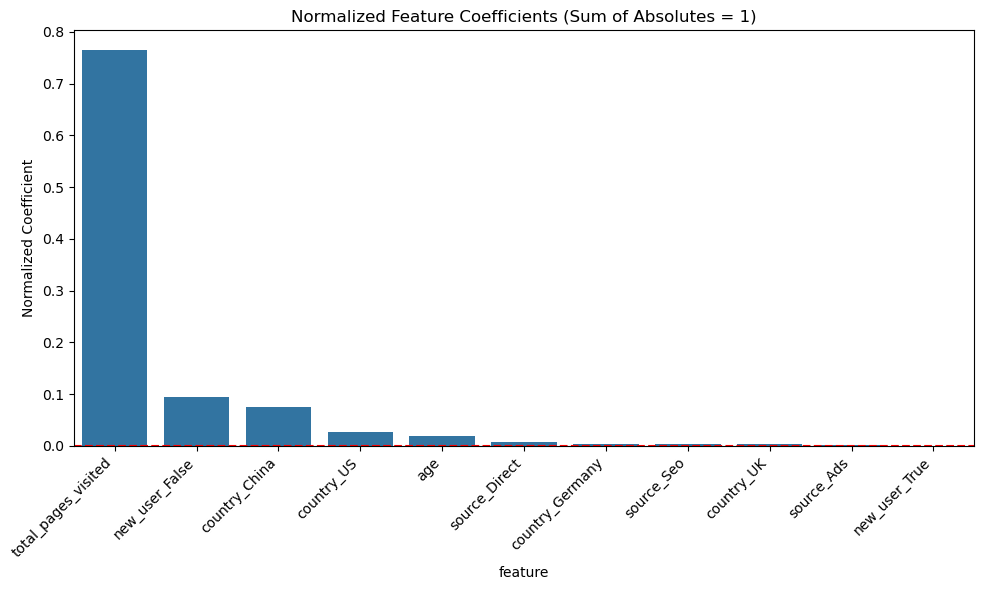

In [ ]:
sum_abs_coef = abs(feature_df_best_model['coef']).sum()
feature_df_best_model['normalized_coef_sum_to_one'] = feature_df_best_model['coef'] / sum_abs_coef

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_df_best_model.sort_values('normalized_coef_sum_to_one', ascending=False, key=abs), x='feature', y='normalized_coef_sum_to_one')
plt.axhline(y=0, color='r', linestyle='--')  #close-to-zero value highlighting
plt.xticks(rotation=45, ha='right')
plt.title('Normalized Feature Coefficients (Sum of Absolutes = 1)')
plt.ylabel('Normalized Coefficient')
plt.tight_layout()
plt.show()

### Our recommendations

There we are: we could interpret the total_pages_visited as the interest shown by users into the content of Data Science Weekly. While it seems to be the main lever in subscribing to the newsletter, the quality of the content is *sort of* expected as such; but how could it be better known?

Being a new user plays no role in subscribing, but age plays a little in it; if we remember our early visuals during EDA, we mostly deal with a younger audience.

While the marketing campaings seem to have little impact, directly reaching out to potential subscribers seems to work best.

As for markets, the Chinese and North American seem to subscribe the most.

Since visitors seem to react the most to the content provided, we could then recommend to Data Science Weekly to give an incentive in registering as a user to see what impact it could have, while targeting North American & Chinese markets for a younger audience!